# Analyse Customer Value by Frequency, Recency and Monetary Value

Customer lifetime value (CLV), is the profit margin a company expects to earn over the entirety of their business relationship with the average customer.

Some contributing factors:
- customer churn rate
- retention rate
- sales & marketing strategy

Business may use strategies such as: 
- **Impress** | by quality/pricing
- **Engage**  | by sales & marketing strategies
- **Retain**  | continue to impress and engage

In this notebook, we explore customer segments by *Frequency*, *Recency* and *Monetary Value*

References: 
- [Customer Lifetime Value](https://clevertap.com/blog/customer-lifetime-value/)
- [Frequency, Recency, Monetary Value Analysis](https://clevertap.com/blog/rfm-analysis/) | [whitepaper](https://info.clevertap.com/hubfs/Blog%20Images/A%20Quick%20Start%20Guide%20to%20Automated%20Segmentation%20(1).pdf) 
- [Customer Segmentation Blog](https://towardsdatascience.com/the-most-important-data-science-tool-for-market-and-customer-segmentation-c9709ca0b64a)

## About Data

Source: https://archive.ics.uci.edu/ml/datasets/online+retail#

**Attribute Information**:

`InvoiceNo`: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with **letter 'c'**, it indicates a **cancellation**.

`StockCode`: Product (item) code. Nominal, a 5-digit integral number **uniquely** assigned to each distinct product.

`Description`: Product (item) name. Nominal.

`Quantity`: The quantities of each product (item) per transaction. Numeric.

`InvoiceDate`: Invice Date and time. Numeric, the day and time when each transaction was generated.

`UnitPrice`: Unit price. Numeric, Product price per unit in **sterling**.

`CustomerID`: Customer number. Nominal, a 5-digit integral number **uniquely** assigned to each customer.

`Country`: Country name. Nominal, the name of the country where each **customer resides**.

# Set up

In [42]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data
## Load Data
Cell below assumed that dataset is registered in AML Workspace.

In [11]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

# Get workspace information
workspace = Workspace.from_config()
print(workspace.name, workspace.resource_group, workspace.location, workspace.subscription_id, sep='\n')

# Get dataset registered in AML workspace by name
dataset = Dataset.get_by_name(workspace, name='online-retail-processed')

# Convert type Dataset to Pandas Dataframe
df_orig = dataset.to_pandas_dataframe()

chyam_aml_tutorial_2022_03
chyam_aml_tutorial_2022_03
westeurope
b5ba1607-7cac-4a12-9477-7853892342c8


## Make a copy

In [15]:
df = df_orig.copy()

# Get info about 'df'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405302 entries, 0 to 405301
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    405302 non-null  object        
 1   StockCode    405302 non-null  object        
 2   Description  405302 non-null  object        
 3   Quantity     405302 non-null  int64         
 4   InvoiceDate  405302 non-null  datetime64[ns]
 5   UnitPrice    405302 non-null  float64       
 6   CustomerID   405302 non-null  object        
 7   Country      405302 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 24.7+ MB


## Prepare Features

### 1. Select Data
- Select data within the range of last 12 months

In [16]:
# Filter data between two dates
df_sub = df.loc[(df['InvoiceDate'] >= '2011-06-1')
           & (df['InvoiceDate'] < '2011-12-1')].copy()

df_sub.describe(include='all', datetime_is_numeric=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,234093,234093,234093,234093.000000,234093,234093.000000,234093,234093
unique,12116,3441,3607,NaN,NaN,NaN,3529,31
top,576339,85123A,white hanging heart t-light holder,NaN,NaN,NaN,17841,United Kingdom
freq,541,1006,999,NaN,NaN,NaN,5034,208345
mean,NaN,NaN,NaN,11.797948,2011-09-11 09:40:37.275853568,3.338185,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,2011-06-01 08:52:00,0.030000,NaN,NaN
25%,NaN,NaN,NaN,2.000000,2011-07-22 13:20:00,1.250000,NaN,NaN
50%,NaN,NaN,NaN,5.000000,2011-09-20 12:35:00,1.690000,NaN,NaN
75%,NaN,NaN,NaN,12.000000,2011-10-30 13:42:00,3.750000,NaN,NaN
max,NaN,NaN,NaN,80995.000000,2011-11-30 17:42:00,38970.000000,NaN,NaN


Note:
- extreme value
    - `Quantity` : -80995, 80995
    - `UnitPrice` : 38970.00

### 2. Effective Quantity

Assume that we are only interested in effective sales, we will exclude return of goods. For example:

Initially bought,
|InvoiceNo  |StockCode  |Description    |Unit   |Date   |UnitPrice  |TotalAmount    |Country|
|---        |---        |---            |---    |---    |---        |---            |---|
|538370	    |84946	    |ANTIQUE SILVER TEA GLASS ETCHED	|6	|12/12/2010 11:06	|1.25	|16923.0	|United Kingdom|


Then returned,
|InvoiceNo  |StockCode  |Description    |Unit   |Date   |UnitPrice  |TotalAmount    |Country|
|---        |---        |---            |---    |---    |---        |---            |---|
|C538372	|84946	    |ANTIQUE SILVER TEA GLASS ETCHED	|-2	|12/12/2010 11:12	|1.25	|16923.0	|United Kingdom|

Effectively, this customer bought 4 units within that period. 

First, group `df_sub` by `CustomerID`, `StockCode`, `UnitPrice`, `Country`, then, get the sum of `Quantity`

In [17]:
# Take the sum when grouped by ['CustomerID', 'StockCode', 'UnitPrice', 'Country']
df_effective_quantity = df_sub.groupby(['CustomerID', 'StockCode', 'UnitPrice', 'Country'], as_index=False, observed=True)['Quantity'].sum() 

# Basic Statstics
df_effective_quantity.describe()

# Display dataframe
df_effective_quantity

,UnitPrice,Quantity
count,174450.000000,174450.000000
mean,3.359781,15.831568
std,96.743554,61.961640
min,0.030000,-1515.000000
25%,0.950000,2.000000
50%,1.690000,6.000000
75%,3.750000,12.000000
max,38970.000000,8972.000000


,CustomerID,StockCode,UnitPrice,Country,Quantity
0,12347,16008,0.25,Iceland,24
1,12347,17021,0.30,Iceland,36
2,12347,20665,2.95,Iceland,6
3,12347,20719,0.85,Iceland,20
4,12347,21041,2.95,Iceland,6
...,...,...,...,...,...
174445,18283,85123A,2.95,United Kingdom,8
174446,18283,90099,2.55,United Kingdom,1
174447,18287,21014,0.29,United Kingdom,24
174448,18287,21824,0.39,United Kingdom,48


### Check for `df_effective_quantity['Quantity'] < 0`

In [18]:
df_effective_quantity[df_effective_quantity['Quantity'] < 0]

,CustomerID,StockCode,UnitPrice,Country,Quantity
1108,12381,21791,1.25,Norway,-12
1118,12381,23198,1.45,Norway,-10
1120,12381,23243,4.95,Norway,-2
1124,12381,85159B,1.95,Norway,-1
1835,12408,20712,2.08,Belgium,-1
...,...,...,...,...,...
173778,18250,22845,6.35,United Kingdom,-1
174102,18272,20932,2.95,United Kingdom,-1
174116,18272,22204,3.75,United Kingdom,-1
174174,18272,84817,2.10,United Kingdom,-2


### Remove `CustomerID` where `df_effective_quantity['Quantity']<0`, if exist

In [20]:
# Define condition
condition = (df_effective_quantity['Quantity']<0)

# Retrieve `CustomerID`, where df_effective_quantity['Quantity']<0
CustomerID_remove = df_effective_quantity[condition]['CustomerID'].unique()

In [21]:
df_sub.shape

# Remove `CustomerID`, where df_effective_quantity['Quantity']<0
df_sub = df_sub[~df_sub['CustomerID'].isin(CustomerID_remove)]

df_sub.shape

(234093, 8)

(164615, 8)

In [22]:
# Show statistics
df_sub.describe(include='all', datetime_is_numeric=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,164615,164615,164615,164615.000000,164615,164615.000000,164615,164615
unique,8131,3335,3471,NaN,NaN,NaN,3014,28
top,567183,85123A,white hanging heart t-light holder,NaN,NaN,NaN,16549,United Kingdom
freq,399,726,722,NaN,NaN,NaN,981,148419
mean,NaN,NaN,NaN,10.231121,2011-09-12 10:00:20.288071168,2.940750,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,2011-06-01 08:52:00,0.040000,NaN,NaN
25%,NaN,NaN,NaN,2.000000,2011-07-25 12:58:00,1.000000,NaN,NaN
50%,NaN,NaN,NaN,5.000000,2011-09-21 14:38:00,1.690000,NaN,NaN
75%,NaN,NaN,NaN,12.000000,2011-10-30 15:08:00,3.750000,NaN,NaN
max,NaN,NaN,NaN,80995.000000,2011-11-30 17:37:00,4161.060000,NaN,NaN


Check that `df_effective_quantity['Quantity'] >= 0`

In [28]:
# Take the sum when grouped by ['CustomerID', 'StockCode', 'UnitPrice', 'Country']
df_effective_quantity = df_sub.groupby(['CustomerID', 'StockCode', 'UnitPrice', 'Country'], as_index=False, observed=True)['Quantity'].sum() 

# check for effective 'Quantity' < 0
len(df_effective_quantity[df_effective_quantity['Quantity'] < 0])

0

Note:
- At this stage, `df_sub`:
    - date range 2021-6-1 to 2021-12-1
    - contains transactions of `CustomerID` where effective `Quantity` is >= 0

In [29]:
df_sub.describe(include='all', datetime_is_numeric=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,164615,164615,164615,164615.000000,164615,164615.000000,164615,164615
unique,8131,3335,3471,NaN,NaN,NaN,3014,28
top,567183,85123A,white hanging heart t-light holder,NaN,NaN,NaN,16549,United Kingdom
freq,399,726,722,NaN,NaN,NaN,981,148419
mean,NaN,NaN,NaN,10.231121,2011-09-12 10:00:20.288071168,2.940750,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,2011-06-01 08:52:00,0.040000,NaN,NaN
25%,NaN,NaN,NaN,2.000000,2011-07-25 12:58:00,1.000000,NaN,NaN
50%,NaN,NaN,NaN,5.000000,2011-09-21 14:38:00,1.690000,NaN,NaN
75%,NaN,NaN,NaN,12.000000,2011-10-30 15:08:00,3.750000,NaN,NaN
max,NaN,NaN,NaN,80995.000000,2011-11-30 17:37:00,4161.060000,NaN,NaN


### 3. Derive new features: `TotalSum`
- `TotalSum` : Create a new column to indicate the total sum of an order, i.e. `Quantity` x `UnitPrice`

In [30]:
# 'TotalSum' = 'Quantity' * 'UnitPrice'
df_sub['TotalSum'] = df_sub['Quantity'] * df_sub['UnitPrice']

# Display 'df_sub'
df_sub

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
28650,540258,20914,set/5 red retrospot lid glass bowls,96,2011-06-01 08:52:00,2.55,14045,United Kingdom,244.80
28651,540258,37449,ceramic cake stand + hanging cakes,36,2011-06-01 08:52:00,8.50,14045,United Kingdom,306.00
28652,540258,21156,retrospot childrens apron,80,2011-06-01 08:52:00,1.65,14045,United Kingdom,132.00
28653,540259,10135,colouring pencils brown tube,40,2011-06-01 09:00:00,0.42,18226,United Kingdom,16.80
28654,540259,21876,pottering mug,36,2011-06-01 09:00:00,0.42,18226,United Kingdom,15.12
...,...,...,...,...,...,...,...,...,...
405297,581587,22613,pack of 20 spaceboy napkins,12,2011-09-12 12:50:00,0.85,12680,France,10.20
405298,581587,22899,children's apron dolly girl,6,2011-09-12 12:50:00,2.10,12680,France,12.60
405299,581587,23254,childrens cutlery dolly girl,4,2011-09-12 12:50:00,4.15,12680,France,16.60
405300,581587,23255,childrens cutlery circus parade,4,2011-09-12 12:50:00,4.15,12680,France,16.60


## Analyse Customer Value by *Frequency, Recency, Monetary*

In [31]:
# Snapshot at latest date of this dataset
snapshot_date = df_sub['InvoiceDate'].max()
snapshot_date

# Calculate Frequency, Recency and Monetary value for each customer
df_frm = df_sub.groupby(['CustomerID']).agg({'InvoiceDate' : lambda x : (snapshot_date - x.max()).days,
                                             'InvoiceNo' : 'count',
                                             'TotalSum' : 'sum'}).rename(columns={'InvoiceDate' : 'Recency(Days)',
                                                                                  'InvoiceNo' : 'Frequency',
                                                                                  'TotalSum' : 'Monetary(£)'})

df_frm

Timestamp('2011-11-30 17:37:00')

,Recency(Days),Frequency,Monetary(£)
CustomerID,,,
12347,30,100,2537.91
12348,66,2,270.00
12349,9,72,1457.55
12352,63,30,512.50
12355,86,13,459.40
...,...,...,...
18276,12,16,323.36
18278,64,9,173.90
18280,150,10,180.60


In [32]:
# Show statistics
df_frm.describe()

,Recency(Days),Frequency,Monetary(£)
count,3014.000000,3014.000000,3.014000e+03
mean,55.295952,54.616788,8.952804e+02
std,51.133530,72.784116,1.713217e+03
min,0.000000,1.000000,-5.684342e-14
25%,13.000000,14.000000,2.439800e+02
50%,40.000000,31.000000,4.757900e+02
75%,85.000000,67.000000,1.031317e+03
max,182.000000,981.000000,6.055199e+04


### Pair Plot

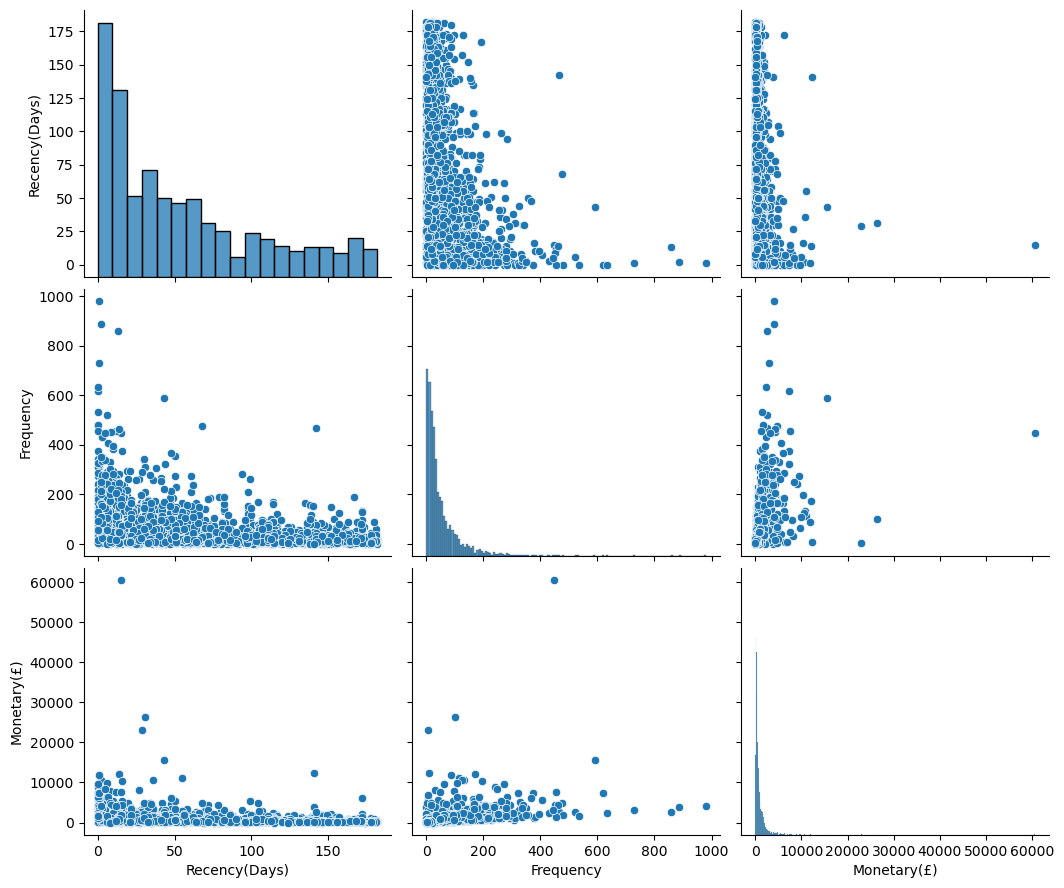

In [39]:
_ = sns.pairplot(df_frm, height=3, aspect=1.2)
plt.show()

### Map `df_rfm` to normal distribution
Pair plot above shows that the distribution for Recency, Frequency, and Monetary are skewed. Here, data transformation is applied to bring the distribution closer to normal distribution. This will aid the subsequent clustering process. 

Data transformation chosen is [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html). You can learn more about mapping one distribution to another via non-linear distribution [here](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-transformer).

In [40]:
from sklearn.preprocessing import PowerTransformer
import pickle

ptransformer = PowerTransformer(method="yeo-johnson")

df_frm_transformed = pd.DataFrame(ptransformer.fit(df_frm).transform(df_frm), 
                                  columns=['Recency(Days)',	'Frequency', 'Monetary(£)'])


if False: 
#if True: # Uncomment to save
    ptransformer_filepath = f'../../.aml/models/powertransformer.pkl'
    pickle.dump(ptransformer, open(ptransformer_filepath, "wb"))

### Register Transformer Model

In [41]:
#if True: 
if False: # Set 'True' to run code below
    from azure.ai.ml import MLClient
    from azure.ai.ml.entities import Model
    from azure.identity import DefaultAzureCredential

    # get a handle to the workspace
    ml_client = MLClient(credential=DefaultAzureCredential(), 
                        subscription_id=workspace.subscription_id, 
                        resource_group_name=workspace.resource_group, 
                        workspace_name=workspace.name)
    ml_client

    model_filepath = f'../../.aml/models/powertransformer.pkl'

    file_model = Model(
        path = model_filepath,
        name = "powertransformer",
        description = "powertransformer.pkl",
        auto_increment_version = True,)
    
    ml_client.models.create_or_update(file_model)

MLClient(credential=<azure.identity._credentials.default.DefaultAzureCredential object at 0x7fe4fb431df0>,
         subscription_id=b5ba1607-7cac-4a12-9477-7853892342c8,
         resource_group_name=chyam_aml_tutorial_2022_03,
         workspace_name=chyam_aml_tutorial_2022_03)

Uploading powertransformer.pkl (< 1 MB): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [00:00<00:00, 29.6kB/s]


Model({'job_name': None, 'is_anonymous': False, 'auto_increment_version': False, 'name': 'powertransformer', 'description': 'powertransformer.pkl', 'tags': {}, 'properties': {}, 'id': '/subscriptions/b5ba1607-7cac-4a12-9477-7853892342c8/resourceGroups/chyam_aml_tutorial_2022_03/providers/Microsoft.MachineLearningServices/workspaces/chyam_aml_tutorial_2022_03/models/powertransformer/versions/3', 'base_path': './', 'creation_context': <azure.ai.ml._restclient.v2022_05_01.models._models_py3.SystemData object at 0x7fe4f86c4f70>, 'serialize': <msrest.serialization.Serializer object at 0x7fe4f4ff5d00>, 'version': '3', 'latest_version': None, 'path': 'azureml://subscriptions/b5ba1607-7cac-4a12-9477-7853892342c8/resourceGroups/chyam_aml_tutorial_2022_03/workspaces/chyam_aml_tutorial_2022_03/datastores/workspaceblobstore/paths/LocalUpload/5f438fda93886b1bebbdeeb47d852770/powertransformer.pkl', 'utc_time_created': None, 'flavors': None, 'arm_type': 'model_version', 'type': 'custom_model'})

### Pair Plot

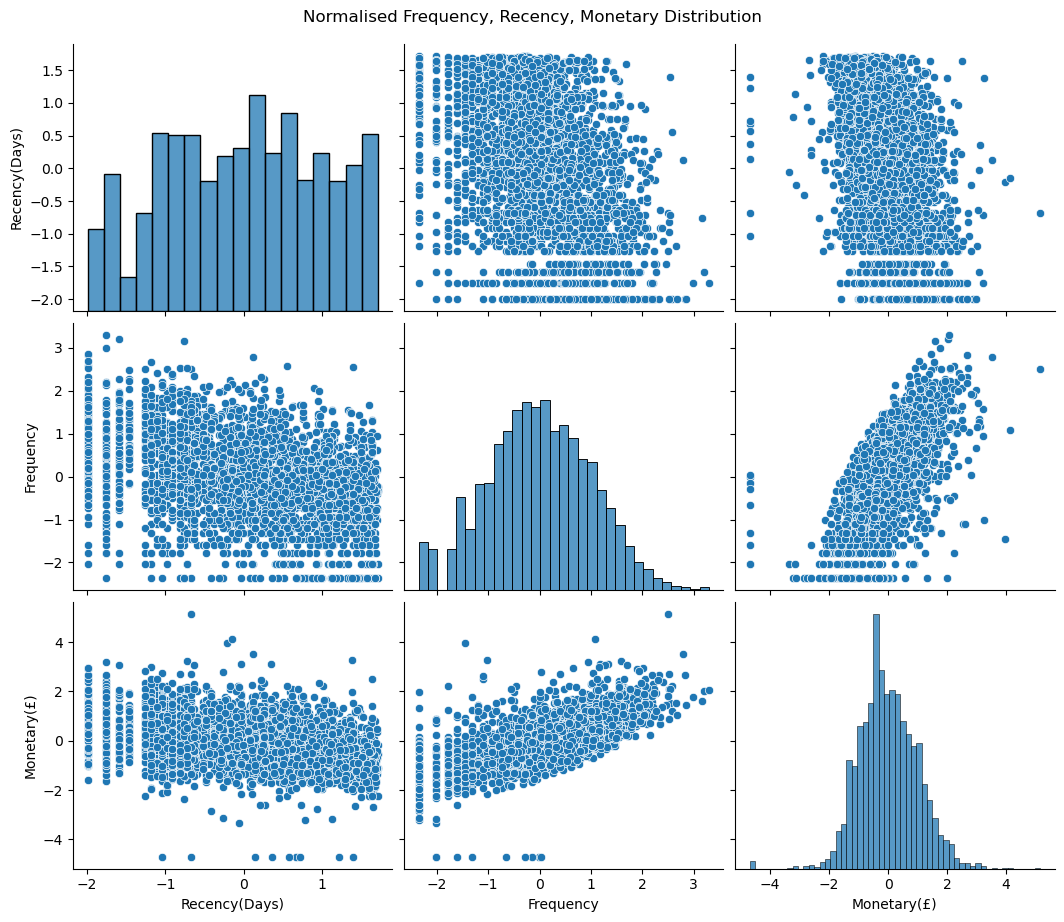

In [45]:
pplt = sns.pairplot(df_frm_transformed, height=3, aspect=1.2)
_ = pplt.fig.suptitle('Normalised Frequency, Recency, Monetary Distribution', y=1.02) # y is position of title
plt.show()

Note that the distribution for Recency, Frequency and Monetary is closer to a normal distribution

# Data Management

## Upload to Blob Storage

In [ ]:
from azureml.core import Workspace, Dataset

datastore = workspace.get_default_datastore()

#if True:
if False: # Set 'True' to run code below
    filename = '../../.aml/data/online-retail-frm.csv'

    # Save to local
    df_frm_transformed.to_csv(filename, index=False)

    # Upload to DataStore
    Dataset.File.upload_directory('../../.aml/data', datastore)

## Register `df_rfm_transformed` as Dataset

In [ ]:
from azureml.core import Workspace, Dataset

datastore = workspace.get_default_datastore()

# if True:
if False: # Set 'True' to run code below

    # Dataset name to register as 
    name = 'online-retail-frm'

    # create a new dataset
    Dataset.Tabular.register_pandas_dataframe(dataframe=df_frm_transformed, 
                                              target=datastore, 
                                              name=name, 
                                              show_progress=True, 
                                              tags={'Purpose':'Tutorial'})